# Import Statements

In [1]:
from numpy.random import seed
seed(888)
import tensorflow as tf
tf.random.set_seed(404)

In [2]:
import os
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import TensorBoard

from time import strftime

from IPython.display import display
from tensorflow.keras.utils import array_to_img

import matplotlib.pyplot as plt

%matplotlib inline

# Constants

In [3]:
LOG_DIR = 'tensorboard_cifar_logs/'

LABEL_NAMES = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
TOTAL_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
NR_CHANNELS = 3
TOTAL_INPUTS = TOTAL_PIXELS * NR_CHANNELS

VALIDATION_SIZE = 10000
SMALL_TRAIN_SIZE = 1000

# Gather Data

In [4]:
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

In [5]:
type(x_train_all)

numpy.ndarray

In [6]:
x_train_all[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

# Exploratory Data Analysis

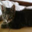

In [7]:
pic = array_to_img(x_train_all[9])
display(pic)

In [8]:
img_type = LABEL_NAMES[y_train_all[9][0]]
img_type

'Cat'

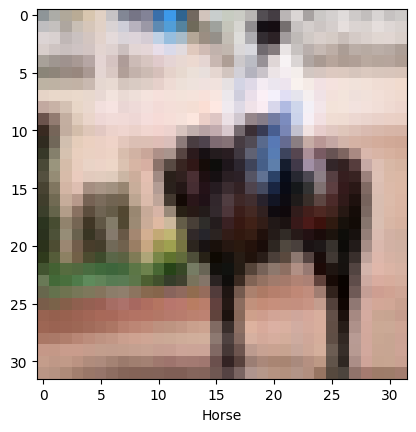

In [9]:
plt.imshow(x_train_all[11])
plt.xlabel(LABEL_NAMES[y_train_all[11][0]])
plt.show()

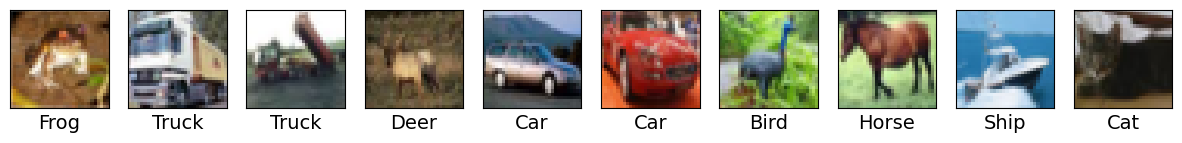

In [10]:
plt.figure(figsize=[15,5], dpi=100)
for x in range(10):
    plt.subplot(1, 10, x+1)
    plt.imshow(x_train_all[x])
    plt.xlabel(LABEL_NAMES[y_train_all[x][0]], fontsize=14)
    #plt.tick_params(left=False, bottom=False)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [11]:
x_train_all.shape

(50000, 32, 32, 3)

In [12]:
nr_images, x, y, z = x_train_all.shape
print(f"Images = {nr_images} | width = {x} | height = {y} | channels = {z}")

Images = 50000 | width = 32 | height = 32 | channels = 3


# Data Preprocessing

In [13]:
type(x_train_all[0][0][0][0]) 
# unint8 => is an unsigned integer (i.e an integer with no sign attached to it e.g 1984 but -2000
# is a signed integer)

numpy.uint8

In [14]:
x_train_all, x_test = x_train_all / 255.0, x_test / 255.0

In [15]:
type(x_train_all[0][0][0][0])

numpy.float64

In [16]:
x_train_all = x_train_all.reshape(len(x_train_all), TOTAL_INPUTS)

In [17]:
x_train_all.shape

(50000, 3072)

In [18]:
%%time
x_test = x_test.reshape(len(x_test), TOTAL_INPUTS)

CPU times: total: 625 ms
Wall time: 5.84 s


In [19]:
x_test.shape

(10000, 3072)

### Creating Validation Dataset

In [20]:
x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]
x_val.shape

(10000, 3072)

In [21]:
x_train = x_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]
x_train.shape

(40000, 3072)

### Create a Smaller Training Dataset

In [22]:
x_train_xs = x_train[:SMALL_TRAIN_SIZE]
y_train_xs = y_train[:SMALL_TRAIN_SIZE]

# Define the Neural Net using Keras

In [23]:
model_1 = Sequential([
    Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu', name='m1_hidden1'),
    Dense(units=64, activation='relu', name='m1_hidden2'),
    Dense(units=16, activation='relu', name='m1_hidden3'),
    Dense(units=10, activation='softmax', name='m1_output')
])

model_1.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [24]:
type(model_1)

keras.engine.sequential.Sequential

In [25]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_hidden1 (Dense)          (None, 128)               393344    
                                                                 
 m1_hidden2 (Dense)          (None, 64)                8256      
                                                                 
 m1_hidden3 (Dense)          (None, 16)                1040      
                                                                 
 m1_output (Dense)           (None, 10)                170       
                                                                 
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


In [26]:
# lets understand how we come about the total params
# prev_unit_of_prev_layer * current_unit + bias
(32*32*3*128+128) + (128*64+64) + (64*16+16) + (16*10+10)

402810

# Visualizing Learning with Tensorboard

In [31]:
def get_tensorboard(model_name):
    folder_name = f"{model_name} on {strftime('%d')}-{strftime('%b')}-{strftime('%y')} at {strftime('%H')}_{strftime('%M')}"
    dir_paths = os.path.join(LOG_DIR, folder_name)
    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print(err.strerror)
    else:
        print('Successfully created directory')

    return TensorBoard(log_dir=dir_paths)
